Alibaba cluster trace v2017
Workload pods + Cluster nodes

Working with modified traces.

In [1]:
import pandas as pd
colnames=['timestamp', 'machine_id', 'event_type', 'event_detail', 'number_of_cpus', 'normalized_memory', 'normalized_disk_space'] 
machine_events = pd.read_csv('server_event_add_only.csv', names=colnames, header=None)
machine_events.describe()

/tmp/ipykernel_38650/2958028088.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,timestamp,machine_id,event_detail,number_of_cpus,normalized_memory,normalized_disk_space
count,1313.0,1313.000000,0.0,1313.0,1313.000000,1313.000000
mean,0.0,657.000000,NaN,64.0,0.692729,0.999286
std,0.0,379.174762,NaN,0.0,0.029690,0.024972
min,0.0,1.000000,NaN,64.0,0.574788,0.095725
25%,0.0,329.000000,NaN,64.0,0.689970,1.000000
50%,0.0,657.000000,NaN,64.0,0.689970,1.000000
75%,0.0,985.000000,NaN,64.0,0.690001,1.000000
max,0.0,1313.000000,NaN,64.0,1.000000,1.000000


In [2]:
colnames=['task_create_time', 'task_end_time', 'job_id', 'task_id', 'number_of_instances', 'status', 'number_of_cpus_requested_per_instance_in_the_task', 'normalized_memory_requested_per_instance_in_the_task'] 
batch_tasks = pd.read_csv('batch_task_fit_only.csv', names=colnames, header=None)
batch_tasks["normalized_memory_requested_per_instance_in_the_task"].quantile(0.75)
batch_tasks.describe()

,task_create_time,task_end_time,job_id,task_id,number_of_instances,number_of_cpus_requested_per_instance_in_the_task,normalized_memory_requested_per_instance_in_the_task
count,53472.000000,53472.000000,53472.000000,53472.000000,53472.000000,53472.000000,53472.000000
mean,33978.867968,34171.588813,6527.972771,40369.946701,160.575067,49.956239,0.007813
std,17210.269129,17160.988692,3609.399784,22767.591623,924.179485,0.945956,0.004554
min,-849.000000,-843.000000,2.000000,2.000000,1.000000,40.000000,0.003815
25%,18968.000000,19726.000000,3787.250000,22596.750000,1.000000,50.000000,0.004110
50%,40447.000000,40577.500000,6846.000000,40529.000000,2.000000,50.000000,0.007941
75%,48350.000000,48426.000000,9017.000000,59288.250000,71.000000,50.000000,0.009334
max,59656.000000,61668.000000,12951.000000,80553.000000,64486.000000,60.000000,0.127332


<Axes: title={'center': 'RAM Utilization'}, xlabel='Timestamp, sec', ylabel='Utilization'>

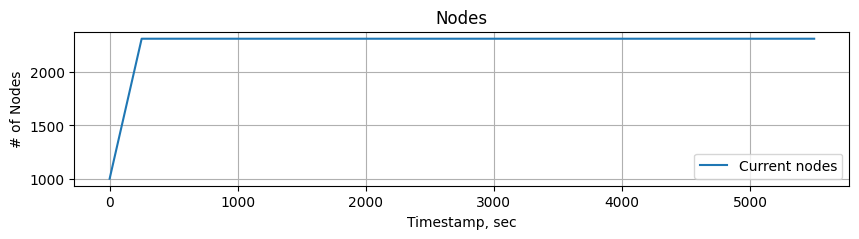

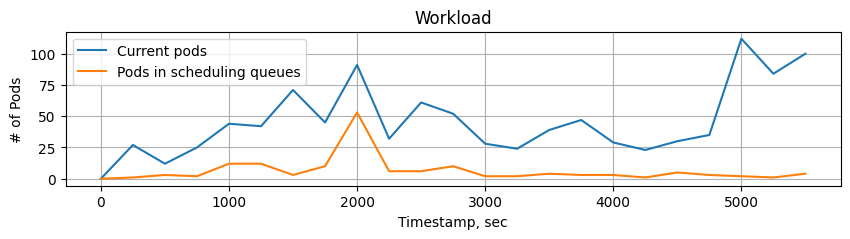

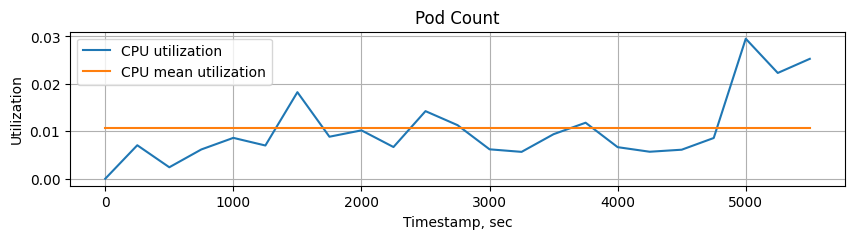

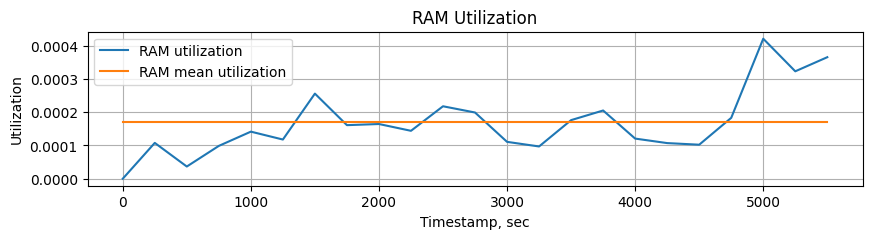

In [5]:
sim_metrics = pd.read_csv('gauge_metrics.csv')
# rename
sim_metrics["Current nodes"] = sim_metrics["current_nodes"]
sim_metrics["Current pods"] = sim_metrics["current_pods"]
sim_metrics["Pods in scheduling queues"] = sim_metrics["pods_in_scheduling_queues"]
sim_metrics["CPU utilization"] = sim_metrics["cluster_total_cpu_utilization"]
sim_metrics["RAM utilization"] = sim_metrics["cluster_total_ram_utilization"]
sim_metrics["CPU mean utilization"] = sim_metrics["cluster_total_cpu_utilization"].mean()
sim_metrics["RAM mean utilization"] = sim_metrics["cluster_total_ram_utilization"].mean()
# make less data due to over sharpness
# yticks=[0.00, 0.02, sim_metrics["CPU mean utilization"][0], 0.04, 0.06, 0.08, 0.10]
# yticks=[0.0000, 0.0005, sim_metrics["RAM mean utilization"][0], 0.0010, 0.0015, 0.0020, 0.0025]
sim_metrics = sim_metrics.iloc[::50, :]
sim_metrics.plot(title="Nodes", x='timestamp', y=["Current nodes"], xlabel="Timestamp, sec", ylabel="# of Nodes", grid=True, figsize=(10,2))
sim_metrics.plot(title="Workload", x='timestamp', y=["Current pods", 'Pods in scheduling queues'], xlabel="Timestamp, sec", ylabel="# of Pods", grid=True, figsize=(10,2))
sim_metrics.plot(title="Pod Count", x='timestamp', y=["CPU utilization", "CPU mean utilization"], xlabel="Timestamp, sec", ylabel="Utilization", grid=True, figsize=(10,2))
sim_metrics.plot(title="RAM Utilization", x='timestamp', y=["RAM utilization", "RAM mean utilization"], xlabel="Timestamp, sec", ylabel="Utilization", grid=True, figsize=(10,2))


<Axes: title={'center': 'Pod Group CPU Mean Utilization'}, xlabel='Timestamp, sec', ylabel='Utilization'>

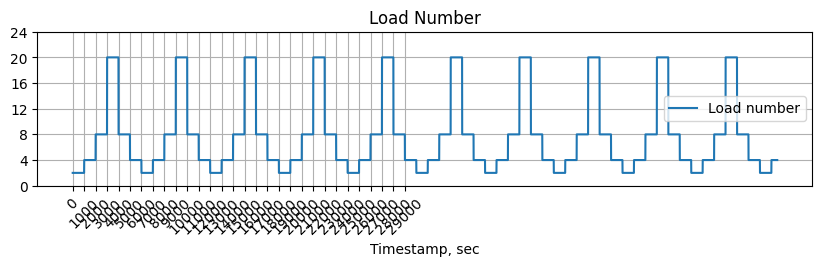

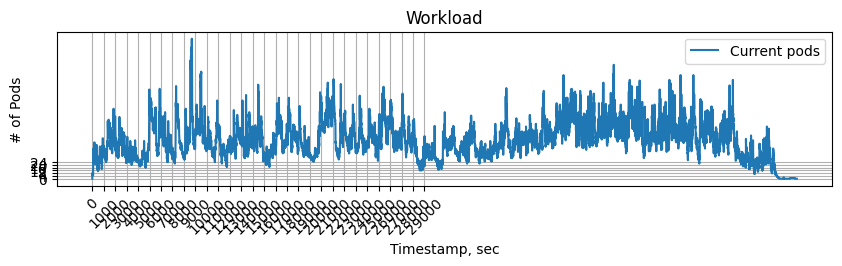

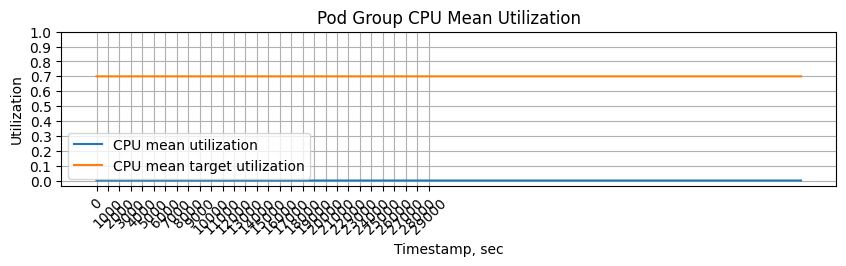

In [3]:
def add_load(row):
    delim = (row["timestamp"] // 1000) % 6
    if delim == 0:
        return 2
    elif delim == 1:
        return 4
    elif delim == 2:
        return 8
    elif delim == 3:
        return 20
    elif delim == 4:
        return 8
    elif delim == 5:
        return 4

sim_metrics = pd.read_csv('gauge_metrics.csv')
# add column of current load
sim_metrics["Load number"] = sim_metrics.apply(add_load, axis=1)
# rename
sim_metrics["Current nodes"] = sim_metrics["current_nodes"]
sim_metrics["Current pods"] = sim_metrics["current_pods"]
sim_metrics["CPU mean utilization"] = sim_metrics["pod_group_cpu_utilization"]
sim_metrics["CPU mean target utilization"] = 0.7

# make less data due to over sharpness
yticks = [i for i in range(0,26,4)]
xticks = [i for i in range(0,30000,1000)]
yticks_util = [i/10 for i in range(0, 11)]
sim_metrics.plot(title="Load Number", x='timestamp', yticks=yticks, xticks=xticks, rot=45, y=["Load number"], xlabel="Timestamp, sec", grid=True, figsize=(10,2))
sim_metrics.plot(title="Workload", x='timestamp', yticks=yticks, xticks=xticks, rot=45, y=["Current pods"], xlabel="Timestamp, sec", ylabel="# of Pods", grid=True, figsize=(10,2))
sim_metrics.plot(title="Pod Group CPU Mean Utilization", x='timestamp', yticks=yticks_util, xticks=xticks, rot=45, y=["CPU mean utilization", "CPU mean target utilization"], xlabel="Timestamp, sec", ylabel="Utilization", grid=True, figsize=(10,2))
